# Bisnis.com News Scraper - Interactive Notebook

This notebook provides an interactive interface for scraping news articles from Bisnis.com with content extraction and translation support.

## Features
- Scrape articles from Bisnis.com
- Extract full article content
- Translate to English and/or Thai
- Interactive data exploration
- Export to multiple formats

## 1. Setup and Installation

In [1]:
# Install required packages
!pip install -q beautifulsoup4 lxml deep-translator pandas matplotlib seaborn


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Import libraries
import json
import logging
import os
import re
import ssl
import gzip
import urllib.request
from datetime import datetime, timedelta
from typing import Optional, List, Dict, Set
from urllib.parse import urljoin
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Create SSL context
ssl_context = ssl.create_default_context()
ssl_context.check_hostname = False
ssl_context.verify_mode = ssl.CERT_NONE

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration

Set your scraping parameters below:

In [3]:
# Configuration widgets
days_widget = widgets.IntSlider(
    value=2,
    min=1,
    max=30,
    step=1,
    description='Days back:',
    style={'description_width': 'initial'}
)

url_widget = widgets.Text(
    value='https://www.bisnis.com/index?categoryId=43',
    description='Base URL:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='100%')
)

fetch_content_widget = widgets.Checkbox(
    value=False,
    description='Fetch full article content',
    style={'description_width': 'initial'}
)

translate_en_widget = widgets.Checkbox(
    value=False,
    description='Translate to English',
    style={'description_width': 'initial'}
)

translate_th_widget = widgets.Checkbox(
    value=False,
    description='Translate to Thai',
    style={'description_width': 'initial'}
)

output_widget = widgets.Text(
    value='news_data.json',
    description='Output file:',
    style={'description_width': 'initial'}
)

# Display configuration
display(widgets.VBox([
    widgets.HTML('<h3>Scraping Configuration</h3>'),
    days_widget,
    url_widget,
    fetch_content_widget,
    widgets.HTML('<h4>Translation Options</h4>'),
    translate_en_widget,
    translate_th_widget,
    widgets.HTML('<h4>Output Settings</h4>'),
    output_widget
]))

## 3. Core Scraping Functions

In [7]:
class BisnisScraperNotebook:
    """Interactive scraper for Bisnis.com with Jupyter notebook support."""
    
    def __init__(self, days_back=2, base_url=None, output_file='news_data.json'):
        self.days_back = days_back
        self.base_url = base_url or 'https://www.bisnis.com/index?categoryId=43'
        self.output_file = output_file
        self.cutoff_date = datetime.now() - timedelta(days=days_back)
        self.existing_urls = set()
        self.article_url_pattern = re.compile(r'/read/(\d{8})/(\d+)/(\d+)/')
        self.scraped_data = []
        self.progress_bar = None
        
    def fetch_url(self, url: str, timeout: int = 30) -> Optional[str]:
        """Fetch URL content using urllib."""
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1'
        }
        
        req = urllib.request.Request(url, headers=headers)
        
        try:
            with urllib.request.urlopen(req, timeout=timeout, context=ssl_context) as response:
                content = response.read()
                if response.info().get('Content-Encoding') == 'gzip':
                    content = gzip.decompress(content)
                
                content_type = response.headers.get('Content-Type', '')
                if 'charset=' in content_type:
                    charset = content_type.split('charset=')[-1].split(';')[0].strip()
                else:
                    charset = 'utf-8'
                
                try:
                    return content.decode(charset)
                except:
                    for enc in ['utf-8', 'iso-8859-1', 'windows-1252']:
                        try:
                            return content.decode(enc, errors='ignore')
                        except:
                            continue
                    return content.decode('utf-8', errors='ignore')
        except Exception as e:
            logger.error(f"Error fetching {url}: {e}")
            return None
    
    def extract_date_from_url(self, url: str) -> Optional[datetime]:
        """Extract date from URL."""
        match = re.search(r'/read/(\d{4})(\d{2})(\d{2})/(\d+)/(\d+)/', url)
        if match:
            year, month, day = match.groups()[:3]
            try:
                return datetime(int(year), int(month), int(day))
            except ValueError:
                return None
        return None
    
    def fetch_page(self, page_num: int) -> Optional[BeautifulSoup]:
        """Fetch a page and return BeautifulSoup object."""
        if '?' in self.base_url:
            url = f"{self.base_url}&page={page_num}"
        else:
            url = f"{self.base_url}?page={page_num}"
        
        try:
            html_content = self.fetch_url(url)
            if html_content is None:
                return None
            return BeautifulSoup(html_content, 'html.parser')
        except Exception as e:
            logger.error(f"Error fetching page {page_num}: {e}")
            return None
    
    def extract_article_data(self, article_elem) -> Optional[Dict]:
        """Extract article data from element."""
        try:
            link_elem = article_elem.find('a', href=True, class_='artLink')
            if not link_elem:
                link_elem = article_elem.find('a', href=True)
            
            if not link_elem:
                return None
            
            url = link_elem['href']
            if not url.startswith('http'):
                url = urljoin("https://www.bisnis.com", url)
            
            if not self.article_url_pattern.search(url):
                return None
            
            title_elem = article_elem.find('h4', class_='artTitle')
            if not title_elem:
                title_elem = link_elem
            
            title = title_elem.get_text(strip=True) if title_elem else "No title"
            article_date = self.extract_date_from_url(url)
            
            channel_elem = article_elem.find('div', class_='artChannel')
            channel = channel_elem.get_text(strip=True) if channel_elem else ""
            
            return {
                'title': title,
                'url': url,
                'date': article_date.isoformat() if article_date else None,
                'date_parsed': article_date,
                'channel': channel,
                'scraped_at': datetime.now().isoformat()
            }
        except Exception as e:
            logger.error(f"Error extracting article: {e}")
            return None
    
    def fetch_article_content(self, url: str) -> Dict:
        """Fetch comprehensive article content."""
        content_data = {
            'content': '',
            'content_html': '',
            'author': '',
            'author_role': '',
            'published_time': '',
            'modified_time': '',
            'tags': [],
            'categories': [],
            'subcategory': '',
            'images': [],
            'summary': '',
            'word_count': 0
        }
        
        try:
            html_content = self.fetch_url(url)
            if html_content is None:
                return content_data
            
            soup = BeautifulSoup(html_content, 'html.parser')
            
            # Extract meta data
            author_meta = soup.find('meta', attrs={'name': 'author'})
            if author_meta:
                content_data['author'] = str(author_meta.get('content', '')).strip()
            
            published_meta = soup.find('meta', attrs={'property': 'article:published_time'})
            if published_meta:
                content_data['published_time'] = str(published_meta.get('content', '')).strip()
            
            modified_meta = soup.find('meta', attrs={'property': 'article:modified_time'})
            if modified_meta:
                content_data['modified_time'] = str(modified_meta.get('content', '')).strip()
            
            # Extract author section
            author_section = soup.find('div', class_='author') or soup.find('div', class_='detail__author')
            if author_section:
                author_name = author_section.find(['h5', 'h4', 'span', 'a'])
                if author_name and not content_data['author']:
                    content_data['author'] = author_name.get_text(strip=True)
                author_role = author_section.find(['span', 'div'], class_=re.compile('role', re.I))
                if author_role:
                    content_data['author_role'] = author_role.get_text(strip=True)
            
            # Extract categories from breadcrumbs
            breadcrumb = soup.find('ul', class_='breadcrumb') or soup.find('nav', class_='breadcrumb')
            if breadcrumb:
                categories = []
                for item in breadcrumb.find_all('li'):
                    link = item.find('a')
                    if link:
                        cat_text = link.get_text(strip=True)
                        if cat_text and cat_text.lower() not in ['home', 'bisnis.com']:
                            categories.append(cat_text)
                content_data['categories'] = categories
                if categories:
                    content_data['subcategory'] = categories[-1] if len(categories) > 1 else categories[0]
            
            # Extract tags
            keywords_meta = soup.find('meta', attrs={'name': 'keywords'})
            if keywords_meta:
                keywords = str(keywords_meta.get('content', ''))
                if keywords:
                    content_data['tags'] = [tag.strip() for tag in keywords.split(',') if tag.strip()]
            
            # Extract content
            content_selectors = ['div.description', 'div.detail__content', 'div.article-content', 'article']
            content_elem = None
            for selector in content_selectors:
                content_elem = soup.select_one(selector)
                if content_elem:
                    break
            
            if content_elem:
                content_data['content_html'] = str(content_elem)
                paragraphs = content_elem.find_all('p')
                if paragraphs:
                    if len(paragraphs) > 0:
                        first_p = paragraphs[0].get_text(strip=True)
                        if len(first_p) > 20:
                            content_data['summary'] = first_p
                    
                    content_text = '\n\n'.join([p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True)])
                    if len(content_text) > 50:
                        content_data['content'] = content_text
                        content_data['word_count'] = len(content_text.split())
                
                # Extract images
                for img in content_elem.find_all('img'):
                    img_src = img.get('src', '')
                    img_alt = img.get('alt', '')
                    if isinstance(img_src, list):
                        img_src = img_src[0] if img_src else ''
                    if img_src and not str(img_src).startswith('data:'):
                        content_data['images'].append({
                            'url': str(img_src),
                            'alt': str(img_alt)
                        })
            
            # Hero image
            hero_img = soup.find('meta', attrs={'property': 'og:image'})
            if hero_img:
                hero_url = str(hero_img.get('content', ''))
                if hero_url and not any(img['url'] == hero_url for img in content_data['images']):
                    content_data['images'].insert(0, {'url': hero_url, 'alt': 'Hero Image', 'is_hero': True})
            
        except Exception as e:
            logger.error(f"Error fetching content: {e}")
        
        return content_data
    
    def scrape(self, fetch_content=False, progress_callback=None):
        """Main scraping method."""
        logger.info(f"Starting scrape with {self.days_back} days back")
        articles = []
        page_num = 1
        
        while True:
            if progress_callback:
                progress_callback(f"Fetching page {page_num}...")
            
            soup = self.fetch_page(page_num)
            if not soup:
                break
            
            art_items = soup.find_all('div', class_='artItem')
            if not art_items:
                break
            
            page_articles = []
            for elem in art_items:
                article = self.extract_article_data(elem)
                if article and article['url'] not in self.existing_urls:
                    page_articles.append(article)
            
            if not page_articles:
                break
            
            # Check date threshold
            all_old = all(
                a.get('date_parsed') and a['date_parsed'] < self.cutoff_date
                for a in page_articles if a.get('date_parsed')
            )
            if all_old:
                break
            
            articles.extend(page_articles)
            
            if progress_callback:
                progress_callback(f"Found {len(articles)} articles so far...")
            
            page_num += 1
            if page_num > 100:
                break
        
        # Fetch content if requested
        if fetch_content and articles:
            for i, article in enumerate(articles):
                if progress_callback:
                    progress_callback(f"Fetching content {i+1}/{len(articles)}: {article['title'][:50]}...")
                
                content_data = self.fetch_article_content(article['url'])
                article.update(content_data)
        
        self.scraped_data = articles
        return articles
    
    def translate_articles(self, articles, target_lang='en', progress_callback=None):
        """Translate articles to target language."""
        try:
            from deep_translator import GoogleTranslator
            translator = GoogleTranslator(source='id', target=target_lang)
        except ImportError:
            logger.error("deep-translator not installed")
            return []
        
        translated = []
        for i, article in enumerate(articles):
            if progress_callback:
                progress_callback(f"Translating to {target_lang}: {i+1}/{len(articles)}")
            
            try:
                trans_article = article.copy()
                
                # Translate fields
                if article.get('title'):
                    trans_article['title'] = translator.translate(article['title'][:4000])
                    trans_article['title_original'] = article['title']
                
                if article.get('content'):
                    content = article['content']
                    if len(content) > 4000:
                        chunks = [content[i:i+4000] for i in range(0, len(content), 4000)]
                        trans_content = ' '.join([translator.translate(chunk) for chunk in chunks])
                    else:
                        trans_content = translator.translate(content)
                    trans_article['content'] = trans_content
                    trans_article['content_original'] = article['content']
                
                if article.get('channel'):
                    trans_article['channel'] = translator.translate(article['channel'])
                    trans_article['channel_original'] = article['channel']
                
                if article.get('author'):
                    trans_article['author'] = translator.translate(article['author'])
                    trans_article['author_original'] = article['author']
                
                trans_article['translated_at'] = datetime.now().isoformat()
                trans_article['translation_source'] = 'id'
                trans_article['translation_target'] = target_lang
                
                translated.append(trans_article)
                
                import time
                time.sleep(0.5)  # Rate limiting
                
            except Exception as e:
                logger.error(f"Translation error: {e}")
                translated.append(article)
        
        return translated
    
    def save_data(self, data, filename=None):
        """Save data to JSON file."""
        filename = filename or self.output_file
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False, default=str)
        logger.info(f"Saved {len(data)} articles to {filename}")
    
    def to_dataframe(self, data=None):
        """Convert scraped data to pandas DataFrame."""
        data = data or self.scraped_data
        if not data:
            return pd.DataFrame()
        return pd.DataFrame(data)

print("✓ BisnisScraperNotebook class defined")

✓ BisnisScraperNotebook class defined


## 4. Run the Scraper

Execute the scraping process with your configured settings:

In [8]:
# Initialize scraper with configuration
scraper = BisnisScraperNotebook(
    days_back=days_widget.value,
    base_url=url_widget.value,
    output_file=output_widget.value
)

# Progress display
progress_label = widgets.Label(value="Ready to scrape...")
display(progress_label)

def update_progress(message):
    progress_label.value = message
    print(message)

# Run scraping
print("\n=== Starting Scraping ===\n")
articles = scraper.scrape(
    fetch_content=fetch_content_widget.value,
    progress_callback=update_progress
)

print(f"\n✓ Scraped {len(articles)} articles")

# Translate to English if requested
if translate_en_widget.value and articles:
    print("\n=== Translating to English ===\n")
    articles_en = scraper.translate_articles(
        articles, 
        target_lang='en',
        progress_callback=update_progress
    )
    scraper.save_data(
        articles_en, 
        filename=output_widget.value.replace('.json', '_translated_en.json')
    )
    print(f"\n✓ Saved {len(articles_en)} English translations")

# Translate to Thai if requested
if translate_th_widget.value and articles:
    print("\n=== Translating to Thai ===\n")
    articles_th = scraper.translate_articles(
        articles, 
        target_lang='th',
        progress_callback=update_progress
    )
    scraper.save_data(
        articles_th, 
        filename=output_widget.value.replace('.json', '_translated_th.json')
    )
    print(f"\n✓ Saved {len(articles_th)} Thai translations")

# Save main data
scraper.save_data(articles)
print(f"\n✓ Saved {len(articles)} articles to {output_widget.value}")

Label(value='Ready to scrape...')

2026-02-19 07:23:54,423 - INFO - Starting scrape with 2 days back



=== Starting Scraping ===

Fetching page 1...
Found 60 articles so far...
Fetching page 2...
Found 120 articles so far...
Fetching page 3...
Found 180 articles so far...
Fetching page 4...
Found 240 articles so far...
Fetching page 5...
Fetching content 1/240: Menteri PKP: Pembangunan 26.000 Huntap di Sumatra ...
Fetching content 2/240: Yang Diuntungkan oleh Stimulus Diskon Tiket Pesawa...
Fetching content 3/240: Isu Perang AS-Iran Bayangi Pasokan, Harga Minyak G...
Fetching content 4/240: Prabowo Pamer Hemat Anggaran Rp303,14 T di Busines...
Fetching content 5/240: Purbaya Buka-bukaan Alasan Maksimalkan Defisit APB...
Fetching content 6/240: RI Gandeng AS Bangun Industri Semikonduktor Senila...
Fetching content 7/240: OPINI: Reformasi Hukum Persaingan Usaha...
Fetching content 8/240: Freeport Sepakat Beri Tambahan 12% Saham untuk RI ...
Fetching content 9/240: Freeport-RI Sepakati Perpanjangan Izin Tambang Usa...
Fetching content 10/240: THR PNS 2026 Segera Cair Awal Ramadan, Ini Bes

2026-02-19 07:30:52,005 - INFO - Saved 240 articles to news_data_new_translated_en.json



✓ Saved 240 English translations

=== Translating to Thai ===

Translating to th: 1/240
Translating to th: 2/240


2026-02-19 07:30:56,087 - ERROR - Translation error: Yang Diuntungkan oleh Stimulus Diskon Tiket Pesawat Lebaran --> No translation was found using the current translator. Try another translator?


Translating to th: 3/240
Translating to th: 4/240
Translating to th: 5/240
Translating to th: 6/240
Translating to th: 7/240
Translating to th: 8/240
Translating to th: 9/240
Translating to th: 10/240
Translating to th: 11/240
Translating to th: 12/240
Translating to th: 13/240
Translating to th: 14/240
Translating to th: 15/240
Translating to th: 16/240
Translating to th: 17/240
Translating to th: 18/240
Translating to th: 19/240
Translating to th: 20/240
Translating to th: 21/240
Translating to th: 22/240
Translating to th: 23/240
Translating to th: 24/240
Translating to th: 25/240
Translating to th: 26/240
Translating to th: 27/240
Translating to th: 28/240
Translating to th: 29/240
Translating to th: 30/240
Translating to th: 31/240
Translating to th: 32/240
Translating to th: 33/240
Translating to th: 34/240
Translating to th: 35/240
Translating to th: 36/240
Translating to th: 37/240
Translating to th: 38/240
Translating to th: 39/240
Translating to th: 40/240
Translating to th: 

2026-02-19 07:38:54,510 - INFO - Saved 240 articles to news_data_new_translated_th.json
2026-02-19 07:38:54,566 - INFO - Saved 240 articles to news_data_new.json



✓ Saved 240 Thai translations

✓ Saved 240 articles to news_data_new.json


## 5. Data Exploration

Explore the scraped data using pandas and visualizations:

In [9]:
# Convert to DataFrame
df = scraper.to_dataframe()

if not df.empty:
    print(f"Total articles: {len(df)}")
    print(f"\nColumns: {list(df.columns)}")
    print("\n=== First few articles ===")
    display(df[['title', 'channel', 'date']].head())
else:
    print("No data available. Please run the scraper first.")

Total articles: 240

Columns: ['title', 'url', 'date', 'date_parsed', 'channel', 'scraped_at', 'content', 'content_html', 'author', 'author_role', 'published_time', 'modified_time', 'tags', 'categories', 'subcategory', 'images', 'summary', 'word_count']

=== First few articles ===


,title,channel,date
0,Menteri PKP: Pembangunan 26.000 Huntap di Suma...,Properti,2026-02-19T00:00:00
1,Yang Diuntungkan oleh Stimulus Diskon Tiket Pe...,Transportasi & Logistik,2026-02-19T00:00:00
2,"Isu Perang AS-Iran Bayangi Pasokan, Harga Miny...",Ekonomi Global,2026-02-19T00:00:00
3,"Prabowo Pamer Hemat Anggaran Rp303,14 T di Bus...",APBN,2026-02-19T00:00:00
4,Purbaya Buka-bukaan Alasan Maksimalkan Defisit...,APBN,2026-02-19T00:00:00


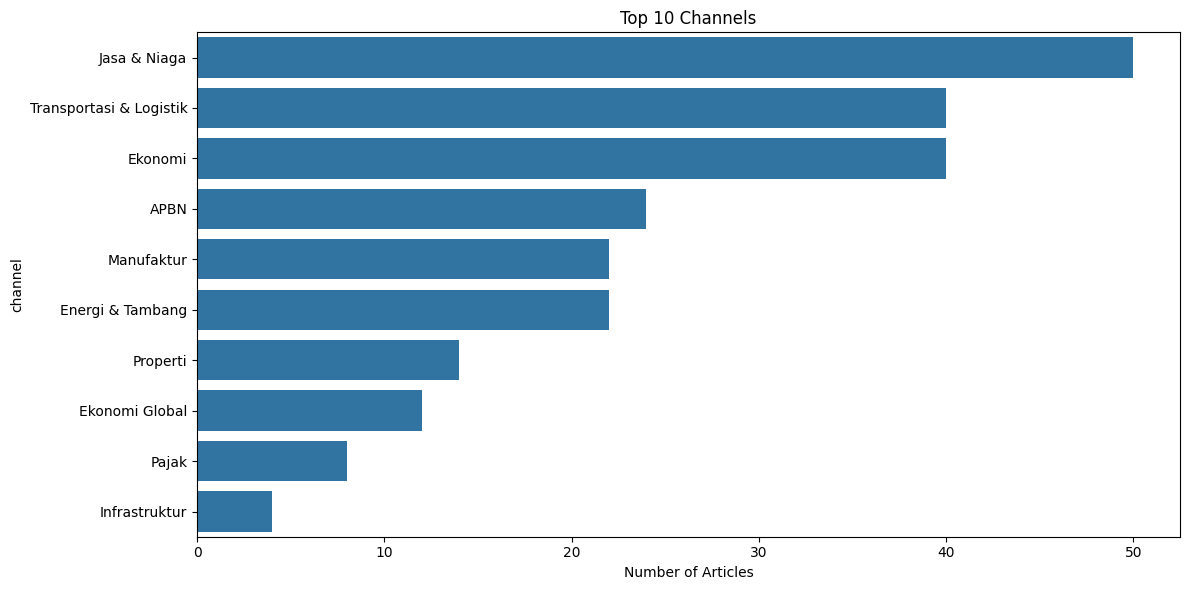


=== Channel Statistics ===
channel
Jasa & Niaga               50
Transportasi & Logistik    40
Ekonomi                    40
APBN                       24
Manufaktur                 22
Energi & Tambang           22
Properti                   14
Ekonomi Global             12
Pajak                       8
Infrastruktur               4
Infrastrukt...              4
Name: count, dtype: int64


In [10]:
# Channel distribution
if not df.empty and 'channel' in df.columns:
    plt.figure(figsize=(12, 6))
    channel_counts = df['channel'].value_counts().head(10)
    sns.barplot(x=channel_counts.values, y=channel_counts.index)
    plt.title('Top 10 Channels')
    plt.xlabel('Number of Articles')
    plt.tight_layout()
    plt.show()
    
    print("\n=== Channel Statistics ===")
    print(df['channel'].value_counts())

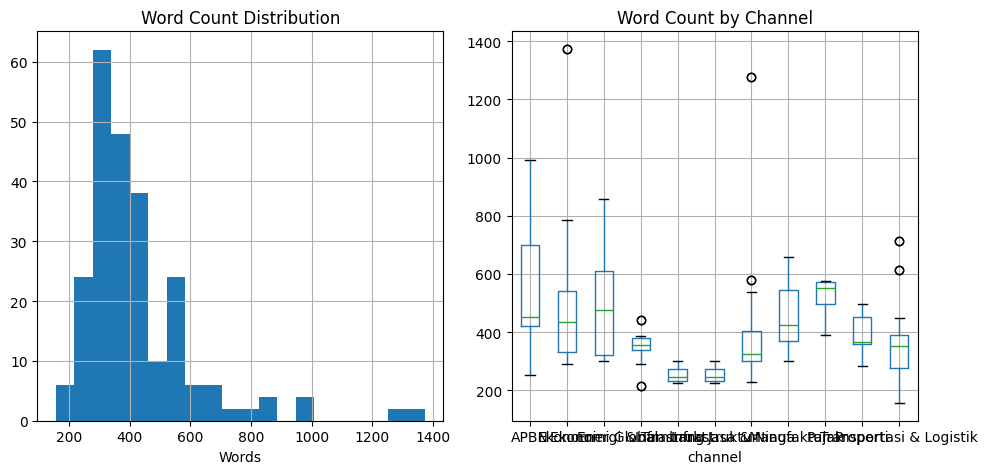


Total words scraped: 102,072
Average words per article: 425


In [11]:
# Content statistics (if content was fetched)
if not df.empty and 'word_count' in df.columns and df['word_count'].sum() > 0:
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    df['word_count'].hist(bins=20)
    plt.title('Word Count Distribution')
    plt.xlabel('Words')
    
    plt.subplot(1, 2, 2)
    df.boxplot(column='word_count', by='channel', ax=plt.gca())
    plt.title('Word Count by Channel')
    plt.suptitle('')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal words scraped: {df['word_count'].sum():,}")
    print(f"Average words per article: {df['word_count'].mean():.0f}")

In [12]:
# View a sample article
if not df.empty:
    sample_idx = 0
    sample = df.iloc[sample_idx]
    
    print("=== Sample Article ===\n")
    print(f"Title: {sample.get('title', 'N/A')}")
    print(f"Channel: {sample.get('channel', 'N/A')}")
    print(f"Date: {sample.get('date', 'N/A')}")
    print(f"URL: {sample.get('url', 'N/A')}")
    
    if 'author' in sample and sample['author']:
        print(f"\nAuthor: {sample['author']}")
    
    if 'summary' in sample and sample['summary']:
        print(f"\nSummary:\n{sample['summary'][:500]}...")
    
    if 'content' in sample and sample['content']:
        print(f"\nContent (first 1000 chars):\n{sample['content'][:1000]}...")

=== Sample Article ===

Title: Menteri PKP: Pembangunan 26.000 Huntap di Sumatra Butuh Rp8,5 Triliun
Channel: Properti
Date: 2026-02-19T00:00:00
URL: https://ekonomi.bisnis.com/read/20260219/47/1954019/menteri-pkp-pembangunan-26000-huntap-di-sumatra-butuh-rp85-triliun

Author: Alifian Asmaaysi

Summary:
Bisnis.com, JAKARTA — Kementerian Perumahan dan Kawasan Permukiman (PKP) mengungkap membutuhkan alokasi anggaran jumbo guna memenuhi pengadaan 26.969 unithuniantetap (huntap) bagi masyarakat terdampakbencana Sumatra....

Content (first 1000 chars):
Bisnis.com, JAKARTA — Kementerian Perumahan dan Kawasan Permukiman (PKP) mengungkap membutuhkan alokasi anggaran jumbo guna memenuhi pengadaan 26.969 unithuniantetap (huntap) bagi masyarakat terdampakbencana Sumatra.

Menteri Perumahan dan Kawasan Permukiman (PKP)Maruarar Siraitmenjelaskan bahwa total kebutuhan dana untuk merealisasikan pembangunan seluruh unit hunian tersebut diproyeksikan tembus Rp8,525 triliun.

"Kami sudah mendata, yang d

## 6. Export Data

Export the scraped data to various formats:

In [ ]:
# Export options
export_format = widgets.RadioButtons(
    options=['JSON', 'CSV', 'Excel'],
    value='JSON',
    description='Format:',
    style={'description_width': 'initial'}
)

export_button = widgets.Button(
    description='Export Data',
    button_style='primary'
)

export_output = widgets.Output()

def on_export_click(b):
    with export_output:
        clear_output()
        if df.empty:
            print("No data to export. Please scrape first.")
            return
        
        base_name = output_widget.value.replace('.json', '')
        
        if export_format.value == 'JSON':
            filename = f"{base_name}_export.json"
            df.to_json(filename, orient='records', indent=2, force_ascii=False)
            print(f"✓ Exported to {filename}")
            
        elif export_format.value == 'CSV':
            filename = f"{base_name}_export.csv"
            df.to_csv(filename, index=False, encoding='utf-8-sig')
            print(f"✓ Exported to {filename}")
            
        elif export_format.value == 'Excel':
            filename = f"{base_name}_export.xlsx"
            df.to_excel(filename, index=False)
            print(f"✓ Exported to {filename}")

export_button.on_click(on_export_click)

display(widgets.VBox([export_format, export_button, export_output]))

## 7. Search and Filter

Search through the scraped articles:

In [14]:
# Search interface
search_box = widgets.Text(
    placeholder='Enter search term...',
    description='Search:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

search_field = widgets.Dropdown(
    options=['title', 'content', 'channel', 'author'],
    value='title',
    description='In field:',
    style={'description_width': 'initial'}
)

search_button = widgets.Button(
    description='Search',
    button_style='info'
)

search_results = widgets.Output()

def on_search_click(b):
    with search_results:
        clear_output()
        if df.empty:
            print("No data to search. Please scrape first.")
            return
        
        query = search_box.value.lower()
        field = search_field.value
        
        if field not in df.columns:
            print(f"Field '{field}' not available in data")
            return
        
        mask = df[field].astype(str).str.lower().str.contains(query, na=False)
        results = df[mask]
        
        print(f"Found {len(results)} matching articles\n")
        
        if len(results) > 0:
            for idx, row in results.head(10).iterrows():
                print(f"{idx+1}. {row['title']}")
                print(f"   Channel: {row.get('channel', 'N/A')} | Date: {row.get('date', 'N/A')}")
                print(f"   URL: {row['url']}")
                print()

search_button.on_click(on_search_click)

display(widgets.VBox([
    widgets.HBox([search_box, search_field]),
    search_button,
    search_results
]))

## Summary

This notebook provides a complete interactive interface for scraping Bisnis.com news articles.

### Features Used:
- Configure scraping parameters with widgets
- Scrape articles with progress tracking
- Extract full content including metadata
- Translate to English and/or Thai
- Explore data with pandas
- Visualize statistics
- Export to multiple formats
- Search and filter results

### Output Files:
- `news_data.json` - Original Indonesian data
- `news_data_translated_en.json` - English translation
- `news_data_translated_th.json` - Thai translation
- Export files in JSON, CSV, or Excel format